##### **Montando nuestro directorio de Drive**

In [1]:
from google.colab import drive

In [10]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS/GAN"

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/DATASETS/GAN


##### **Importando librerías**

In [30]:
# generales:
import os
import h5py
import cv2 as cv
from PIL import Image
import numpy as np
import tensorflow as tf

print('tensorflow version', tf.__version__)

tensorflow version 2.4.1


In [12]:
# para las redes neuronales:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new!
from keras.utils.vis_utils import plot_model
from keras.optimizers import RMSprop, SGD

In [13]:
# para plotting:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### **Importando el dataset**

In [39]:
def loadImgs(batch=1000):
  imgs = []
  fileList = []
  
  for root, dirs, files in os.walk("./cats"):
      for file in files:
          if file.endswith(".jpg"):
              fileList.append(file)

  for src in fileList[:batch]:
      img = Image.open(os.path.join("./cats", src))
      imgs.append(np.asarray(img))

  return imgs

In [41]:
imgs = loadImgs(batch=2000)
print(np.array(imgs).shape)

(2000, 64, 64, 3)


(2000, 64, 64, 1)


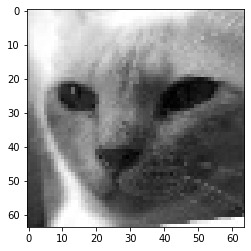

In [80]:
# cargamos las imagenes
cats = np.array(imgs)[:, :, :, 0]
cats = cats.reshape(cats.shape[0], cats.shape[1], cats.shape[2], 1)
print(cats.shape)
plt.imshow(cats[3, :, :, 0], cmap='gray')
plt.show()

## **Red Adversarial**

In [81]:
class GANNetwork:
  def __init__(self, data, z_dim, filename):
    # parametros para la red GAN
    self._data  = data
    self._z_dim = z_dim
    self._filename = filename
    self._img_w, self._img_h = self._data.shape[1:3]

    # instanciamos y compilamos nuestra red discriminadora
    self.discriminator = self._discriminatorBuilder()
    # instanciamos nuestra red generadora
    self.generator = self._generatorBuilder(z_dim=self._z_dim)
    # instanciamos y compilamos nuestra red adversarial
    self.adversarial = self._adversarialBuilder(z_dim=self._z_dim)


  def _discriminatorBuilder(self, depth=64, p=0.4):
      model = Sequential(name='Discriminator')
      # normal
      model.add(Conv2D(64, (3,3), padding='same', input_shape=(self._img_w, self._img_h, 1)))
      model.add(LeakyReLU(alpha=0.2))
      # downsample
      model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # downsample
      model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # downsample
      model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # classifier
      model.add(Flatten())
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      # compile model
      model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                    metrics=['accuracy'])
      return model

      
  def _generatorBuilder(self, z_dim=32, depth=64, p=0.4):
      model = Sequential(name='Generator')
      # foundation for 4x4 image
      n_nodes = 256 * 4 * 4
      model.add(Dense(n_nodes, input_dim=z_dim))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Reshape((4, 4, 256)))
      # upsample to 8x8
      model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # upsample to 16x16
      model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # upsample to 32x32
      model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # upsample to 64x64
      model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      # output layer
      model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
      return model


  def _adversarialBuilder(self, z_dim=32):
      model = Sequential(name='Adversarial')
      # Hacer pesos en la red discriminadora no entrenables
      self.discriminator.trainable = False
      # las redes generadora y discriminadora en cascada
      model.add(self.generator)
      model.add(self.discriminator)
      # compilamos la red adversarial
      model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                    metrics=['accuracy'])
      
      return model


  def generateRealImgs(self, data, batch=128):
      # muestrear imagenes reales
      realImgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, self._img_w, self._img_h, 1))
      # generar los targets para las imagenes reales (1)
      realTrgs = np.ones((batch, 1))

      return realImgs, realTrgs


  def generateLatentSpace(self, z_dim=32, batch=128):
      # generamos el espacio latente
      return np.random.uniform(-1.0, 1.0, size=[batch, z_dim])


  def generateFakeImgs(self, z_dim=32, batch=128):
      # generamos el espacio latente
      X = self.generateLatentSpace(z_dim=self._z_dim, batch=batch)
      # generar imagenes falsas
      fakeImgs = self.generator.predict(X)
      # generar los targets para las imagenes falsas (0)
      fakeTrgs = np.zeros((batch, 1))

      return fakeImgs, fakeTrgs 


  def train(self, epochs=2000, z_dim=32, batch=128, instances=8, save=False):
    # guardaremos las métricas de desempeño tanto de la red adversarial
    # como de la red discriminadora
    advrMetrics = []
    discMetrics = []
    
    # particionamos el batch para reales y falsas
    halfBatch = int(batch/2)

    for epoch in range(epochs):
        # (1) ENTRENAMIENTO DE LA RED DISCRIMINADORA
        realX, realY = self.generateRealImgs(data=self._data, batch=halfBatch)
        fakeX, fakeY = self.generateFakeImgs(z_dim=self._z_dim, batch=halfBatch)
        # creando una solo dataset
        X = np.concatenate((realX, fakeX))
        y = np.concatenate((realY, fakeY))
        # entrenar la red
        discMetrics.append(self.discriminator.train_on_batch(X, y))

        # (2) ENTRENAMIENTO DE LA RED GAN
        # generamos el espacio latente
        X = self.generateLatentSpace(z_dim=self._z_dim, batch=batch)
        # creamos etiquetas invertidas para las muestras falsas
        y = np.ones([batch, 1])
        # entrenar la red
        advrMetrics.append(self.adversarial.train_on_batch(X, y))
        
        # mostramos el progreso del entrenamiento y las imagenes que se van generando
        if (epoch + 1) % 100 == 0:
            print('epoch #{}'.format(epoch + 1))
            # generamos imagenes a partir de un espacio latente con
            # un numero determinado de instancias
            imgs = self.generator.predict(self.generateLatentSpace(z_dim=self._z_dim, batch=instances))
            # dibujamos las imagenes
            plt.figure(figsize=(5, 5))
            for k in range(imgs.shape[0]):
                plt.subplot(1, instances,  k + 1)
                plt.imshow(imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
        
    # guaramos los pesos de la red generadora
    if save:
        self.generator.save(self._filename)


    return advrMetrics, discMetrics

In [82]:
gan = GANNetwork(data=cats, z_dim=100, filename='GAN_model_cats.h5')

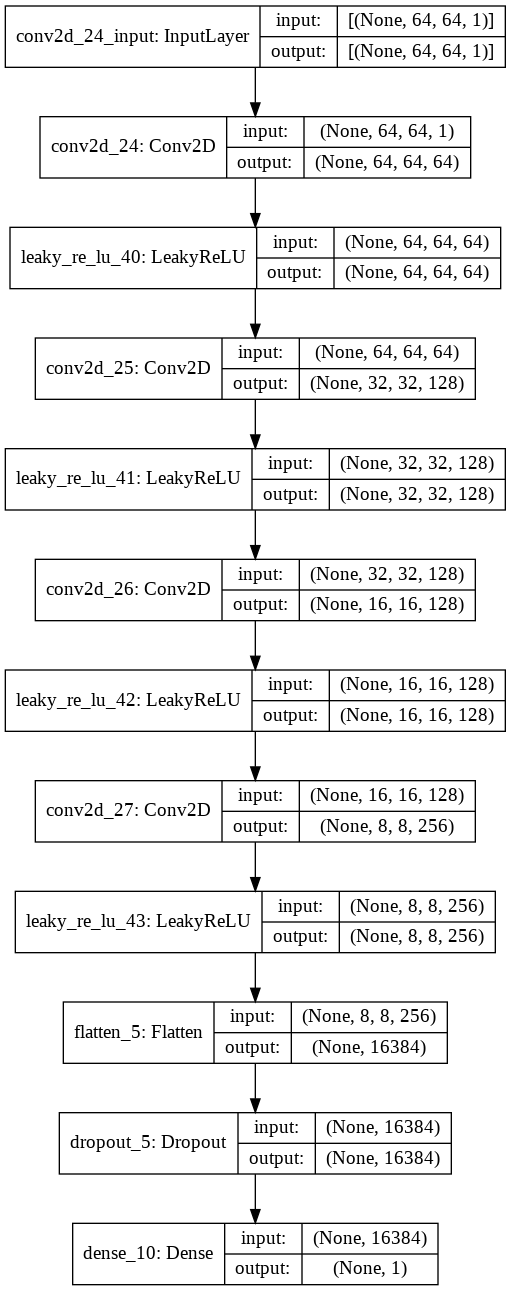

In [84]:
# gan.discriminator.summary()
plot_model(gan.discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

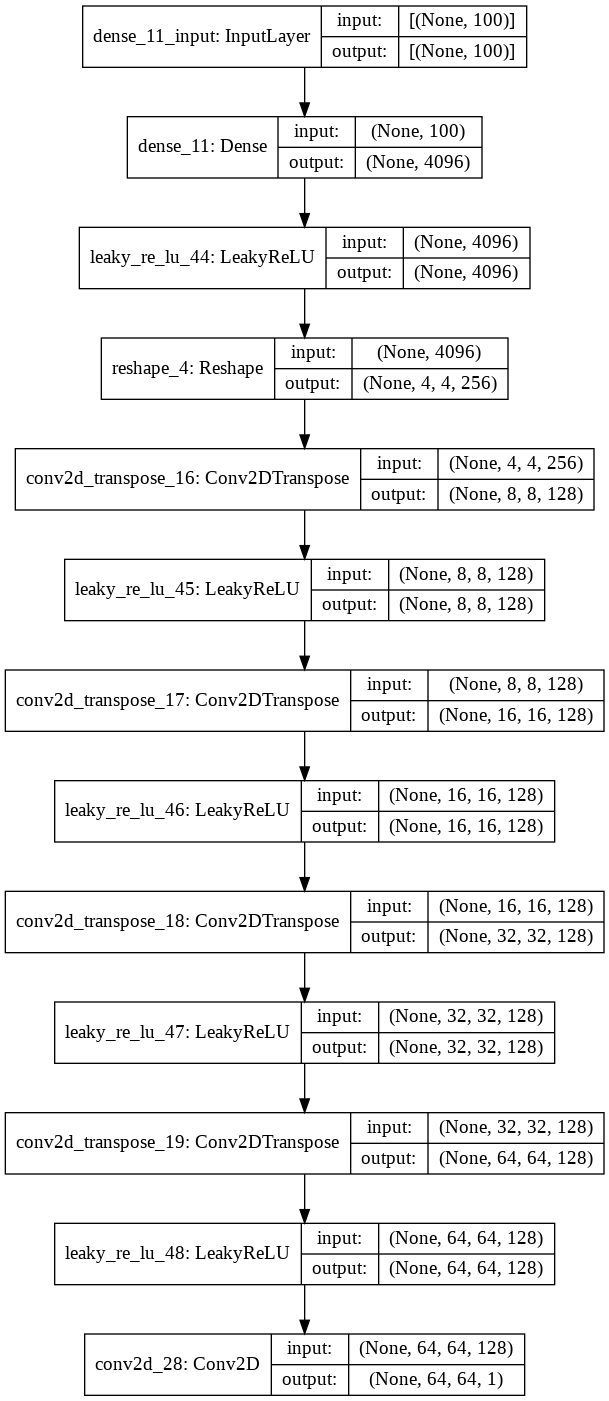

In [85]:
# gan.generator.summary()
plot_model(gan.generator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

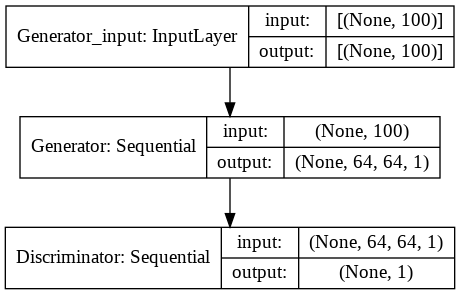

In [86]:
# gan.adversarial.summary()
plot_model(gan.adversarial, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [87]:
# almacenar las métricas de desempeño en caso de correr el algoritmo más de una vez
advrMetrics = []
discMetrics = []

epoch #100


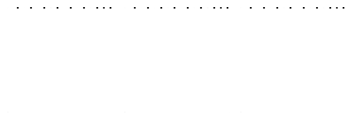

epoch #200


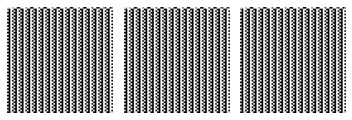

epoch #300


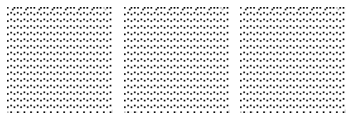

epoch #400


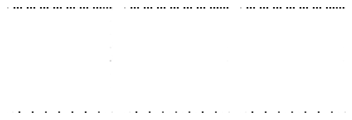

epoch #500


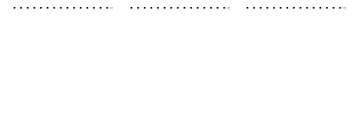

epoch #600


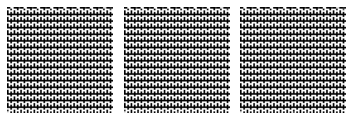

epoch #700


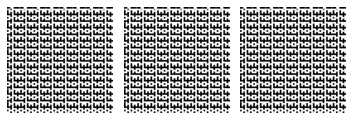

epoch #800


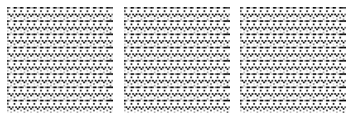

epoch #900


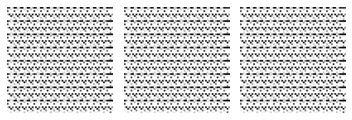

epoch #1000


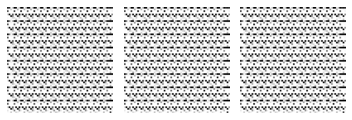

epoch #1100


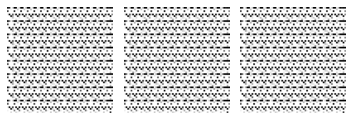

epoch #1200


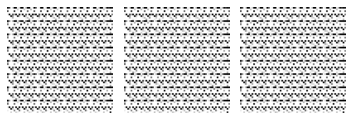

epoch #1300


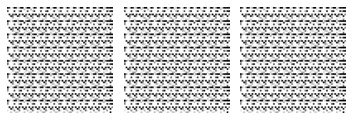

epoch #1400


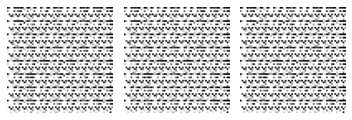

epoch #1500


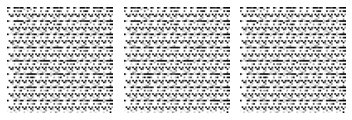

epoch #1600


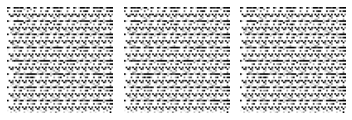

epoch #1700


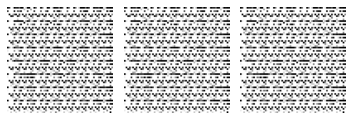

epoch #1800


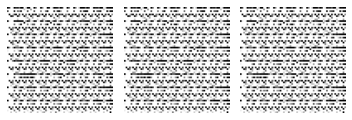

epoch #1900


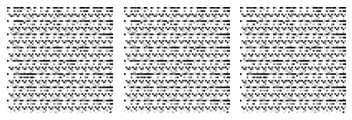

epoch #2000


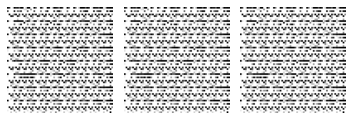

In [88]:
# ejecutamos el algoritmo
aMetrics, dMetrics = gan.train(epochs=2000, instances=3, save=True)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics

In [91]:
# ejecutamos el algoritmo
aMetrics, dMetrics = gan.train(epochs=3000, instances=3, save=True)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics

Output hidden; open in https://colab.research.google.com to view.

In [93]:
# ejecutamos el algoritmo
aMetrics, dMetrics = gan.train(epochs=5000, instances=3, save=True)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics

Output hidden; open in https://colab.research.google.com to view.

##### **Métricas del desempeño de las redes**

[]

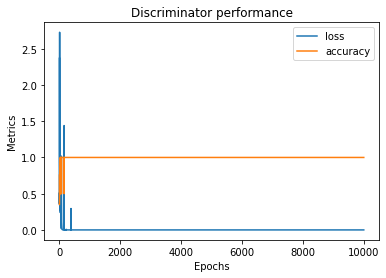

In [94]:
# mostrando el loss de la red discriminadora
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in discMetrics],
    'accuracy': [metric[1] for metric in discMetrics],
  }
).plot(title='Discriminator performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

[]

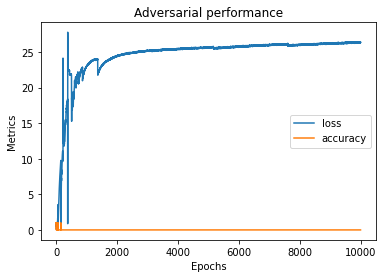

In [95]:
# mostrando el loss de la red adversarial
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in advrMetrics],
    'accuracy': [metric[1] for metric in advrMetrics],
  }
).plot(title='Adversarial performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()